### Importing libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

### Creating directory for visualization

In [6]:
import pathlib
from config import config, initializing
initializing()

pathlib.Path(config['visualization_dir']).mkdir(
        parents=True, exist_ok=True)

### Read dataset

In [48]:
names = ['age','workclass','fnlwgt','education','education-num',
        'marital-status','occupation','relationship','race','sex',
        'capital-gain','capital-loss','hours-per-week','native-country',
        'y']

#Load dataset
df = pd.read_csv('/home/mdsamiul/github_project/fair_classifier_ml/data/adult.data',names=names,na_values='?', sep=r'\s*,\s*')
df = df.dropna() # remove missing value

print("Length of the dataset: ",len(df))
print("The dataset shape: ",df.shape)

Length of the dataset:  30162
The dataset shape:  (30162, 15)


### Dataset related information

In [63]:
# See to 10 row of the dataset

# df[['age','education-num','marital-status','occupation',
#     'hours-per-week','native-country',
#     'race','sex','y']].head(10)
df.head().T

,0,1,2,3,4
age,39,50,38,53,28
workclass,State-gov,Self-emp-not-inc,Private,Private,Private
fnlwgt,77516,83311,215646,234721,338409
education,Bachelors,Bachelors,HS-grad,11th,Bachelors
education-num,13,13,9,7,13
marital-status,Never-married,Married-civ-spouse,Divorced,Married-civ-spouse,Married-civ-spouse
occupation,Adm-clerical,Exec-managerial,Handlers-cleaners,Handlers-cleaners,Prof-specialty
relationship,Not-in-family,Husband,Not-in-family,Husband,Wife
race,White,White,White,Black,Black
sex,Male,Male,Male,Male,Female


In [50]:
# See information of each column

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  int64 
 1   workclass       30162 non-null  object
 2   fnlwgt          30162 non-null  int64 
 3   education       30162 non-null  object
 4   education-num   30162 non-null  int64 
 5   marital-status  30162 non-null  object
 6   occupation      30162 non-null  object
 7   relationship    30162 non-null  object
 8   race            30162 non-null  object
 9   sex             30162 non-null  object
 10  capital-gain    30162 non-null  int64 
 11  capital-loss    30162 non-null  int64 
 12  hours-per-week  30162 non-null  int64 
 13  native-country  30162 non-null  object
 14  y               30162 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [51]:
# See the description of those columns that has numerical values

df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [46]:
# See the unique value of each column

df.nunique()

age                  72
workclass             7
fnlwgt            20263
education            16
education-num        16
marital-status        7
occupation           14
relationship          6
race                  5
sex                   2
capital-gain        118
capital-loss         90
hours-per-week       94
native-country       41
y                     2
dtype: int64

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

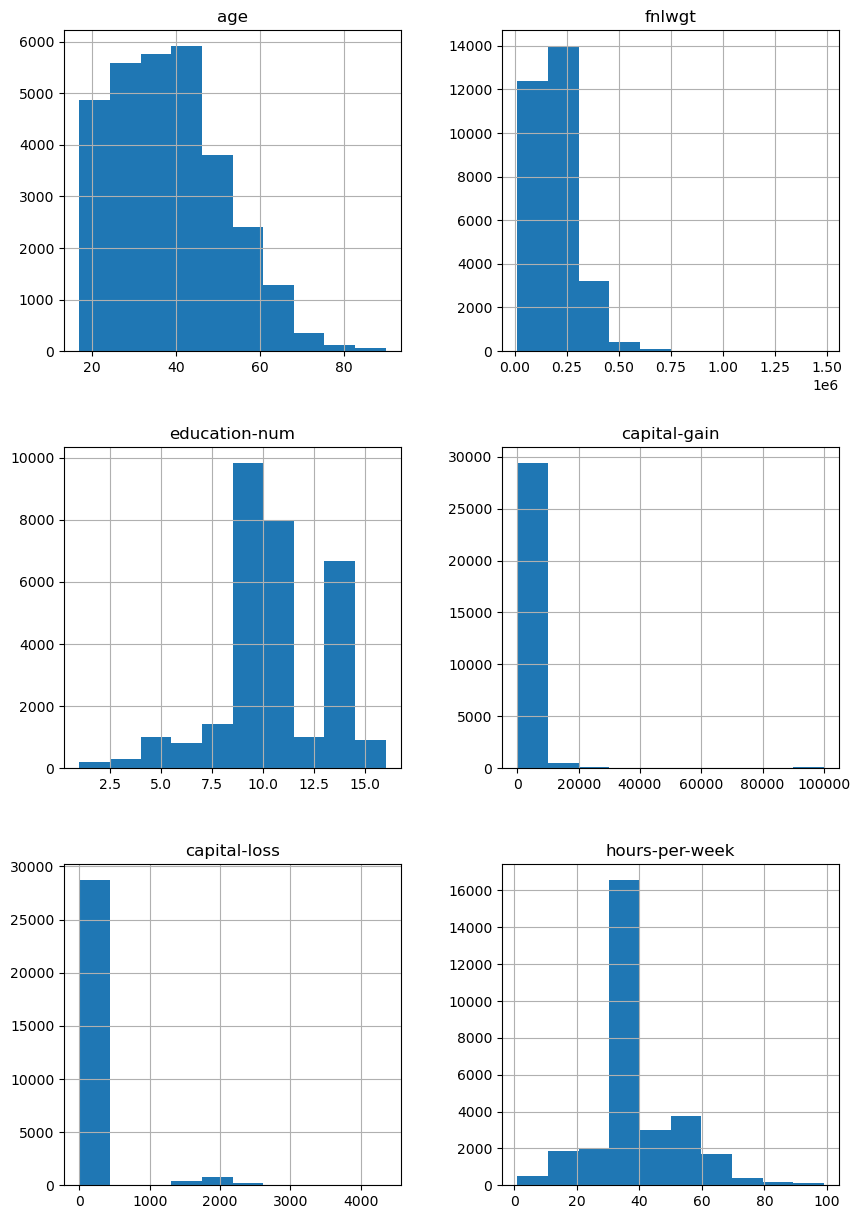

In [53]:
df.hist(bins=10, figsize=(10, 15))

### Unbalanced dataset

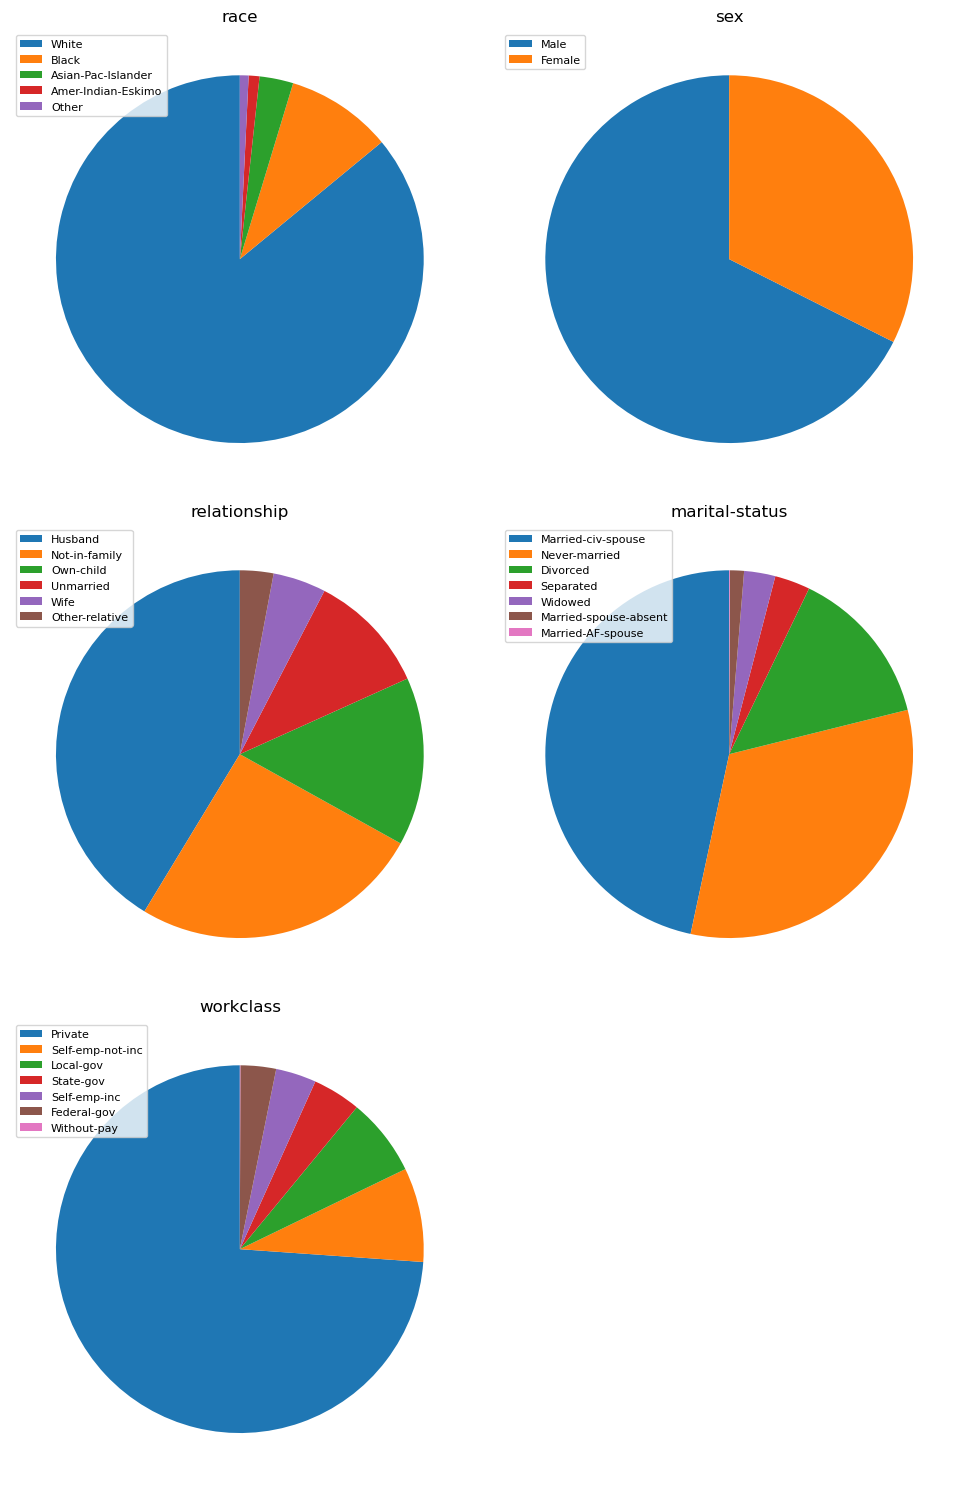

In [87]:
# 'native-country','occupation','education', 
col = ['race', 'sex',  'relationship', 'marital-status', 'workclass']

plt.figure(figsize=(10, 15))

len = 1
for i in col:
    plt.subplot(320+len)
    counts = df[i].value_counts()
    labels = counts.index
    plt.pie(counts, startangle=90)
    plt.legend(labels, loc=2, fontsize=8)
    plt.title(i, size=12)
    len = len + 1

plt.tight_layout()
plt.savefig(config['visualization_dir']+'unbalnced_datsets.png' ,format='png', bbox_inches='tight', dpi=150)

### Defining protected features

In [34]:
df_fair = df[['race','sex']]

#Define protected variables 
df_fair['priv_race'] = [1 if r=='White' else 0 for r in df_fair['race']]
df_fair['priv_sex'] = [1 if s=='Male' else 0 for s in df_fair['sex']]

#Define target variable 
df_fair['y'] =  [1 if y == '>50K'else 0 for y in df['y']]

df_fair.head(10)

/home/mdsamiul/anaconda3/envs/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/mdsamiul/anaconda3/envs/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/mdsamiul/anaconda3/envs/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

,race,sex,priv_race,priv_sex,y
0,White,Male,1,1,0
1,White,Male,1,1,0
2,White,Male,1,1,0
3,Black,Male,0,1,0
4,Black,Female,0,0,0
5,White,Female,1,0,0
6,Black,Female,0,0,0
7,White,Male,1,1,1
8,White,Female,1,0,1
9,White,Male,1,1,1


### Prevelance

In [35]:
#Calculate prevelance
prev = df_fair['y'].mean()
prev_race = df_fair.groupby('priv_race')['y'].mean()
prev_sex = df_fair.groupby('priv_sex')['y'].mean()
prev_comb = df_fair.groupby(['priv_race','priv_sex'])['y'].mean()

print(prev)
print(prev_race)
print(prev_sex)
print(prev_comb)

0.24892248524633645
priv_race
0    0.158193
1    0.263718
Name: y, dtype: float64
priv_sex
0    0.113678
1    0.313837
Name: y, dtype: float64
priv_race  priv_sex
0          0           0.074722
           1           0.225448
1          0           0.122989
           1           0.325313
Name: y, dtype: float64


### Proxy Variable

In [36]:
#Target variable 
y = [1 if y == '>50K' else 0 for y in df['y']]

#Model features
X = df[['age','education-num','hours-per-week']]
X['marital-status'] = [1 if x=='Married-civ-spouse' else 0 for x in df['marital-status']] 
X['native-country'] = [1 if x=='United-States' else 0 for x in df['native-country']] 

occ_groups = {
    'Priv-house-serv':0,'Other-service':0,'Handlers-cleaners':0,
    'Farming-fishing':1,'Machine-op-inspct':1,'Adm-clerical':1,
    'Transport-moving':2,'Craft-repair':2,'Sales':2,
    'Armed-Forces':3,'Tech-support':3,'Protective-serv':3,
    'Prof-specialty':4,'Exec-managerial':4}

X['occupation'] = [occ_groups[x] for x in df['occupation']]

X.head()

/home/mdsamiul/anaconda3/envs/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mdsamiul/anaconda3/envs/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdsamiul/anaconda3/envs/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

,age,education-num,hours-per-week,marital-status,native-country,occupation
0,39,13,40,0,1,1
1,50,13,13,1,1,4
2,38,9,40,0,1,0
3,53,7,40,1,1,0
4,28,13,40,1,0,4


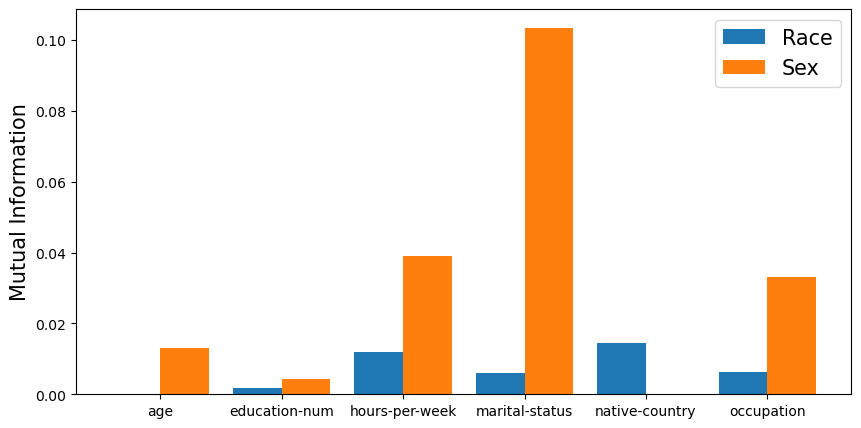

In [38]:
#Mutual information 

#Calcualte mutual information
mut_race = mutual_info_classif(X,df_fair['priv_race'],discrete_features=[1,3,4,5])
mut_sex = mutual_info_classif(X,df_fair['priv_sex'],discrete_features=[1,3,4,5])


#Plot mutual information 
plt.figure(figsize=(10, 5))

labels = ['age', 'education-num', 'hours-per-week', 'marital-status',
       'native-country', 'occupation']
x = np.arange(len(labels)) 
width = 0.4
plt.bar(x-width/2,height= mut_race,width=width,label='Race')
plt.bar(x+width/2,height= mut_sex,width=width,label='Sex')
plt.legend(fontsize=15)

plt.ylabel('Mutual Information',size=15)
plt.xticks(ticks=x,labels=labels)

plt.savefig(config['visualization_dir']+"Mutual_information.png", dpi=100)